In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
print('OpenCV version used:', cv2.__version__)
from glob import glob

from matplotlib import pyplot as plt
from scipy.io import loadmat
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20,20)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
OpenCV version used: 4.1.2


In [12]:

import os # accessing directory structure
print(os.listdir('../input/cv-course/module4-geometry/practice1_camera_calibration/img/'))

['P1020848LinesAndVP.mat', 'P1020848.jpg']


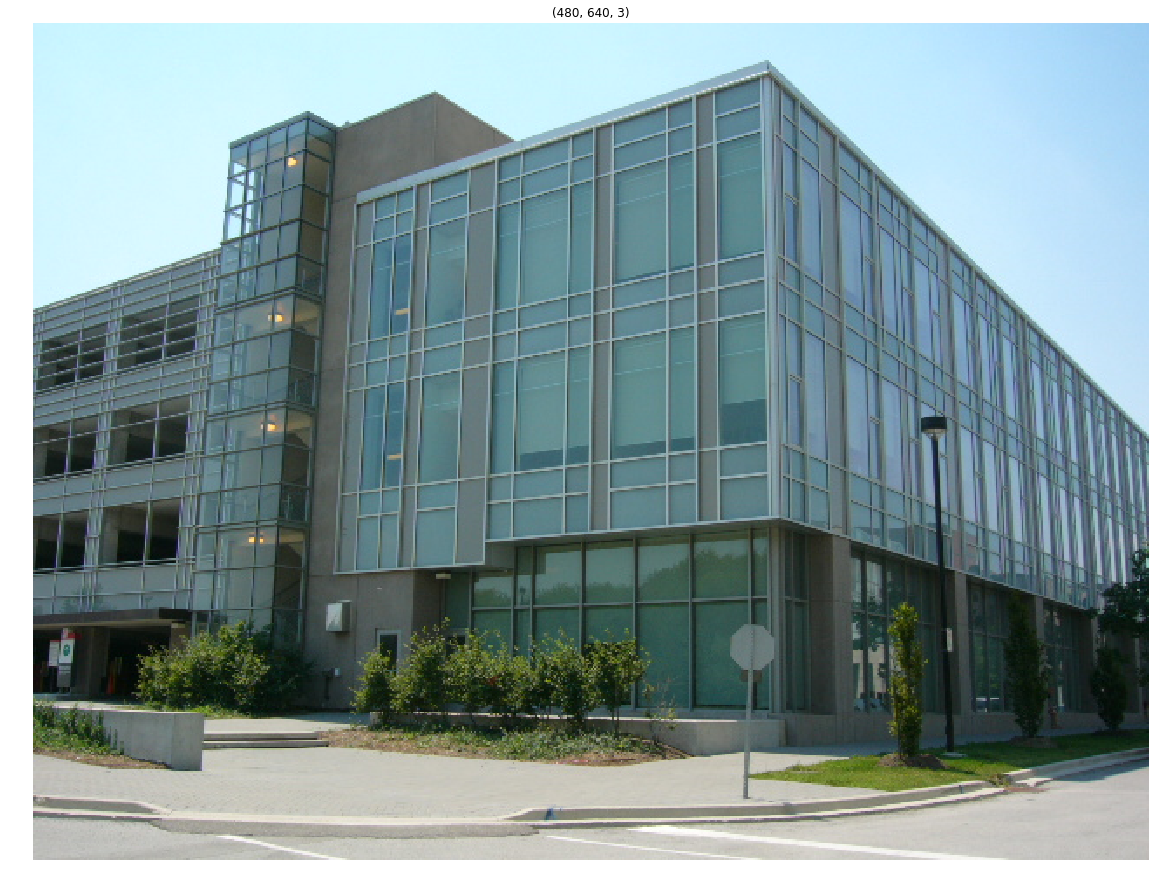

In [13]:
def imread(imgpath):
    return cv2.cvtColor(cv2.imread(imgpath), cv2.COLOR_BGR2RGB)

# def url_to_image(url):
#     print("downloading %s" % (url))
#     return io.imread(url)

def imshow(img, cmap='gray', sub=None, title=None, ax='off'):
    if sub is not None:
        plt.subplot(*sub)
    if title is None:
        title = img.shape
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.grid(False)
    plt.axis(ax)
    if sub is None:
        plt.show()

# Load image
img = imread('../input/cv-course/module4-geometry/practice1_camera_calibration/img/P1020848.jpg')
#img = url_to_image("https://raw.githubusercontent.com/ucuapps/computer-vision-course/master/module4-geometry/practice1_camera_calibration/img/P1020848.jpg")[:500,:,:]
imshow(img)

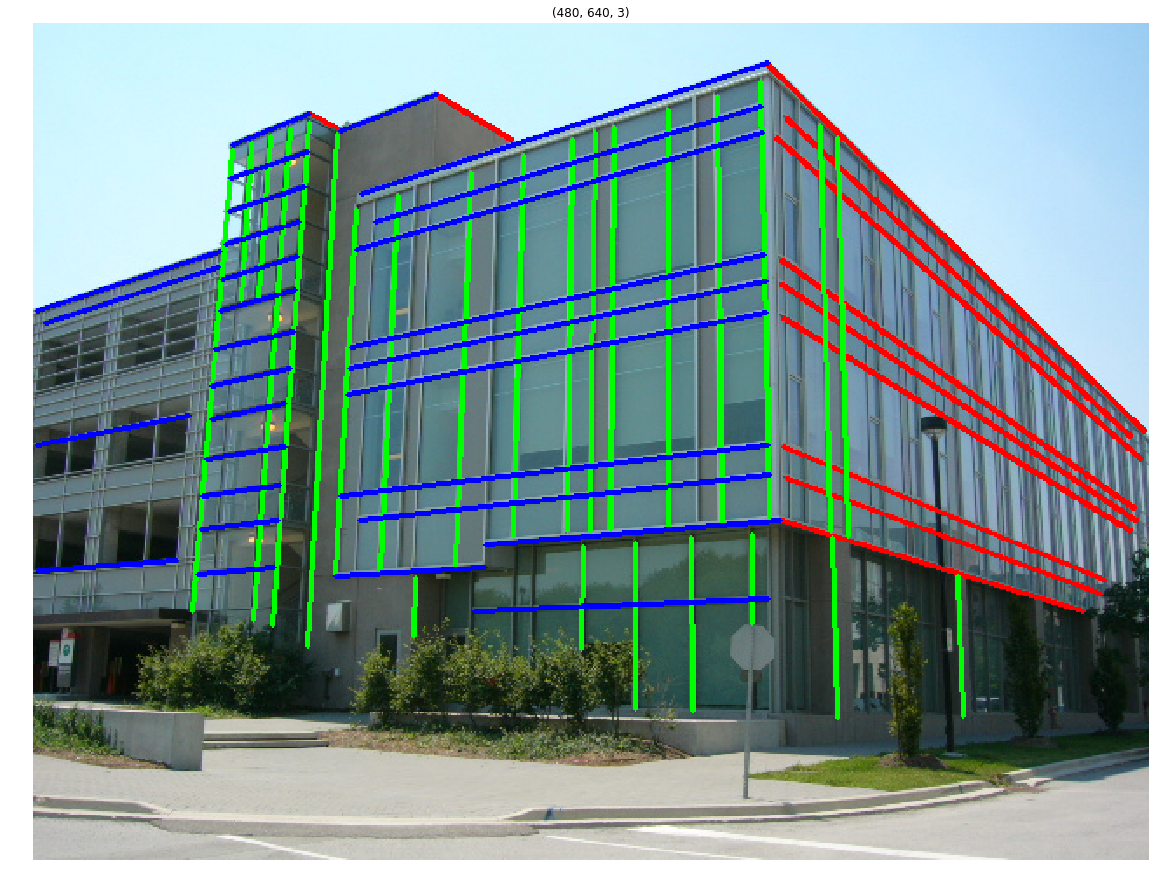

In [14]:
# Load lines and vanishing point assignments (labels) for lines
data = loadmat("../input/cv-course/module4-geometry/practice1_camera_calibration/img/P1020848LinesAndVP.mat")
lines = data['lines'].reshape(65,4)
vp_labels = np.array(data['vp_association']).squeeze()

vp_colors = [(255,0,0), (0,255,0), (0,0,255)]
img_with_lines = img.copy()
for (line, vp) in zip(lines, vp_labels):
    x1, y1, x2, y2 = line
    img_with_lines = cv2.line(img_with_lines, (x1,y1), (x2,y2), vp_colors[vp-1], 2)

imshow(img_with_lines)

## Task 1.1
Implement basic functions for homogeneous coordinates and computation of the line from two image points

In [15]:
def homogenize(pts):
    """Transform image points from 2D coordinates to homogeneous coordinates. 
    Args:
        pts -- (N,2) array of image points in 2D
    Returns:
        pts_h -- (N,3) array -- pts in homogeneous representation
    """

    pts_h = np.c_[pts, np.ones(pts.shape[0])]
    
    return pts_h

def renormalize(pts):
    """Renormalize image points in homogeneous representation
      (i.e. project on the plane z=1, divide by the third coordinate)
    Args:
        pts -- (N,3) array of image points in homogeneous representation
    Returns:
        pts_norm -- (N,3) array -- pts divided by the third coordinate
    """
    vec_4_norm = pts.T[-1]
    #When the number = 0.5 I suppose that it should be rounded to 1, not to 0. That is why I added 0.1 to each number.
    pts_norm = np.round((pts + 0.1) / vec_4_norm[:, None])
    return pts_norm
    

def line_from_two_points(pts1, pts2):
    """Get line from two image points that belong to this line
    Args:
        pts1 -- image points in 2D
        pts2 -- image points in 2D
    Returns:
        line -- line in homogeneous representation
    """
    points =np.vstack((pts1, pts2))
    pts_h = homogenize(points)
    [x1, y1, w1], [x2, y2, w2] = renormalize(pts_h).astype(int)
    line = np.array([y1 * w2 - y2 * w1,
                    x2 * w1 - x1 * w2, x1 * y2 - x2 * y1])
    
    return line

lines_homogeneous = np.array([line_from_two_points(l[0:2], l[2:4]) for l in lines])
print(lines_homogeneous)

[[  -210    216  83226]
 [   -26     43   4243]
 [     9    -16   -599]
 [   -52    173 -26997]
 [  -184    209  64590]
 [  -142    202  33446]
 [  -135    203  27465]
 [  -122    199  18829]
 [   -76    184 -12032]
 [  -182    197  67789]
 [   -66    180 -18468]
 [   293     17 -52070]
 [  -288    -21  46701]
 [  -281    -21  42588]
 [   -92     -7  12967]
 [   -90     -6  11664]
 [  -264    -23  31775]
 [  -209    -12  39949]
 [   -99      1  37028]
 [   -95      0  32775]
 [   -59     -1  18885]
 [   -33     -1   7545]
 [   -51      0  21012]
 [  -250      5 104080]
 [  -103      3  46289]
 [   -80      3  41449]
 [  -244      3  95522]
 [  -238      0  86632]
 [  -230     -2  76710]
 [  -224     -3  69417]
 [  -225     -9  57249]
 [  -215    -10  45925]
 [  -218     -6  61714]
 [  -228     -3  73605]
 [  -228      6 104712]
 [  -232      6 104278]
 [   -75   -233  36934]
 [   -21    -55   7106]
 [   -18    -44   5132]
 [   -34   -105  17393]
 [    14    169 -54157]
 [    -5    -86 

## Task 1.2
Implement estimation of the intersection point from more than 2 lines (it's an overdetermined case, so try SVD as earlier) 

In [24]:
#from numpy.linalg import svd
def point_from_lines(lines):
    """
    Args:
        lines -- (N,3) array of N lines in homogeneous representation
    Returns:
        pt -- estimated point of intersection
    """
    points = []
    for l1 in lines:
        for l2 in lines:
            if not np.array_equal(l1,l2):
                points.append(np.dot(l1,l2))
    u, s, vh = svd(points)
    print(vh[:,-1])
    return np.array(vh[:,-1])

vp = np.zeros((3,3))
for label in [1,2,3]:
    vp[label-1,:] = point_from_lines(lines_homogeneous[vp_labels==label])

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

## Task 2
Let's assume that the camera has zero skew and that the pixels are square. Then the principal point can be computed as the orthocenter of an orthogonal triad of vanishing points. Estimate it and compute focal length with given vanishing points and estimated principal point.

In [ ]:
from utils import triangle_orthocenter

def autocalibrate(vp):
    """Autocalibrate from three orthogonal vanishing points
    Args:
        pts -- (N,3) array of N vanishing points in homogeneous representation (N=3)
    Returns:
        K -- (3,3) camera calibration matrix
    """
    ########### please implement me ###########
    pass
    ###########################################
    return K

In [ ]:
K = autocalibrate(vp)
K

## Task 3
Now try it with your camera -- take a photo of a scene where you could obtain three vanishing points. Find the lines. You can do it 1) manually or 2) automatically (detect edges, fit the lines e.g. with Hough transform). Label lines to orthogonal directions and estimate vanishing points. In the second case suggest a robust way to estimate vanishing points from detected lines. Find the camera matrix. You will use it in the next lab.